In [9]:
import os
os.environ['JAX_ENABLE_X64'] = '1'

In [17]:
import numpy as np
import jax.numpy as jnp
from temgym_core.components import Lens, Detector
from temgym_core.ray import GaussianRay
from temgym_core.gaussian import get_image

In [18]:
%matplotlib widget
import matplotlib.pyplot as plt

In [ ]:
# Detector setup
pixel_size = 5e-6
shape = (2048, 2048)

In [20]:
# Model Creation
f=5e-3
z2 = (1 / f) ** -1 + 2e-3
model = [Lens(z=0.0, focal_length=f), Detector(z=z2, pixel_size=(pixel_size, pixel_size), shape=shape)]

In [21]:
# Gaussian Beam Input
xs = jnp.array([0.0, 0.5e-3])
ys = jnp.array([0.0, 0.5e-3])
dxs = jnp.array([0.0, 0.0])
dys = jnp.array([0.0, 0.0])
zs = jnp.array([0.0, 0.0])
pathlengths = jnp.array([0.0, 0.0])
ones = jnp.array([1.0, 1.0])
amplitudes = jnp.array([1.0, 1.0])
wavelength = 1e-4
wo = 0.5e-3
k = 2 * jnp.pi / wavelength

rays = GaussianRay(x=xs, 
                   y=ys, 
                   dx=dxs, 
                   dy=dys, 
                   z=zs, 
                   pathlength=pathlengths, 
                   _one=ones, 
                   amplitude=amplitudes, 
                   waist_xy=jnp.array([[wo, wo], [wo, wo]]), 
                   radii_of_curv=jnp.array([[jnp.inf, jnp.inf], [jnp.inf, jnp.inf]]), 
                   wavelength=wavelength, 
                   theta=jnp.array([0.0, 0.0]))

In [22]:
det_image = get_image(rays, model)

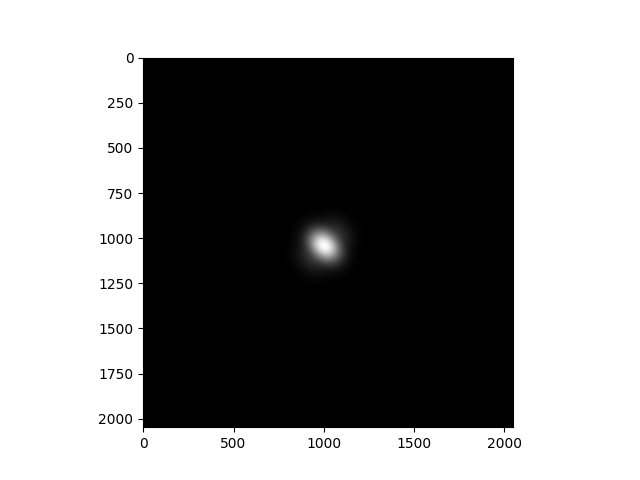

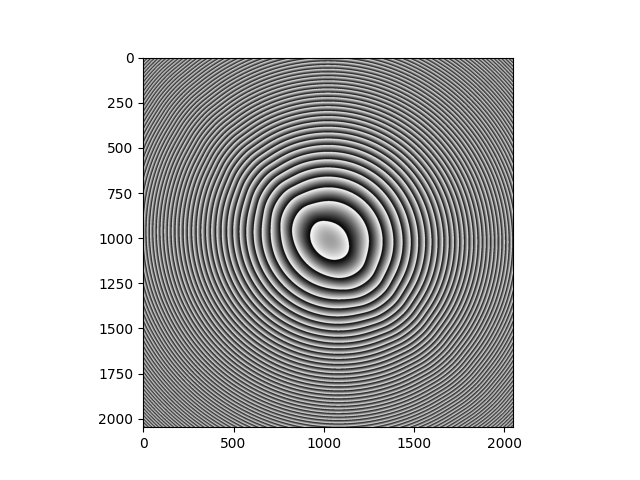

In [24]:
fig, ax = plt.subplots()
ax.imshow(np.abs(det_image), cmap="gray")

fig, ax = plt.subplots()
ax.imshow(np.angle(det_image), cmap="gray")